c:\Users\Gabriele\anaconda3\envs\trioma\Lib\site-packages\TRIOMA\tools\extractor.py:343: OptimizeWarning: Unknown solver options: xatol, fatol
  c_out = minimize(
c:\Users\Gabriele\anaconda3\envs\trioma\Lib\site-packages\TRIOMA\tools\extractor.py:154: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  integral = integrate.quad(toint, c_out, c_in, points=c_out_max, maxp1=1e3)


Warning!: guessed length is not equal to the height. Double check your result 0.05340358157252812 0.3
TRIOMA eff is  0.013062253575418792
eff_res is  0.012907306582303737
err is  -0.00015494699311505503


c:\Users\Gabriele\anaconda3\envs\trioma\Lib\site-packages\TRIOMA\tools\extractor.py:154: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = integrate.quad(toint, c_out, c_in, points=c_out_max, maxp1=1e3)


Warning!: guessed length is not equal to the height. Double check your result 0.05725492635134092 0.725
The sweep gas saturated
 Longer column would not increment the extraction efficiency
TRIOMA eff is  0.013981326148739592
eff_res is  0.013780006198760412
err is  -0.00020131994997918054
Warning!: guessed length is not equal to the height. Double check your result 0.05725492635134092 1.15
The sweep gas saturated
 Longer column would not increment the extraction efficiency
TRIOMA eff is  0.013981326148739592
eff_res is  0.013796191238516022
err is  -0.00018513491022357012
Warning!: guessed length is not equal to the height. Double check your result 0.05725492635134092 1.575
The sweep gas saturated
 Longer column would not increment the extraction efficiency
TRIOMA eff is  0.013981326148739592
eff_res is  0.013800760083196646
err is  -0.00018056606554294613
Warning!: guessed length is not equal to the height. Double check your result 0.05725492635134092 2.0
The sweep gas saturated
 Long

c:\Users\Gabriele\anaconda3\envs\trioma\Lib\site-packages\TRIOMA\tools\extractor.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1 / (


TRIOMA eff is  0.05984819979891687
eff_res is  0.05928975246366269
err is  -0.0005584473352541752
Warning!: guessed length is not equal to the height. Double check your result 0.2712275857699572 1.575
TRIOMA eff is  0.0645606593012018
eff_res is  0.06378843156416482
err is  -0.0007722277370369873
Warning!: guessed length is not equal to the height. Double check your result 0.2818111983529513 2.0
TRIOMA eff is  0.06695129616919226
eff_res is  0.06592200673662271
err is  -0.0010292894325695523
Warning!: guessed length is not equal to the height. Double check your result 0.1315196374701823 0.3
TRIOMA eff is  0.0323552451113972
eff_res is  0.03229361924624945
err is  -6.16258651477547e-05
Warning!: guessed length is not equal to the height. Double check your result 0.26381523903265236 0.725
TRIOMA eff is  0.06339679732612424
eff_res is  0.06313356540632471
err is  -0.00026323191979953087
Warning!: guessed length is not equal to the height. Double check your result 0.3522605153059681 1.15
T

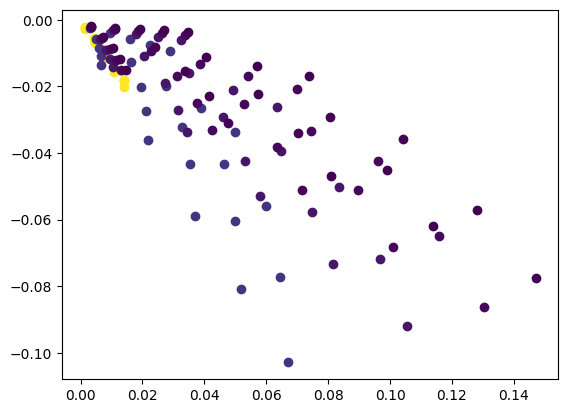

In [1]:
from TRIOMA.tools.component_tools import GLC,GLC_Gas,Fluid
import numpy as np 
import matplotlib.pyplot as plt
import mph 
R_const=8.31
T = 673
Z = 0.8
R = 0.03
Q_l = 80.0 * 1e-3 / 360
Q_gas=np.linspace(6* 1e-3 / 3600,100*1e-3/3600,5)
L_on_g=Q_l/Q_gas
p_in = 1E4
B_vec = []
kl_vec = []
client=mph.start()
model = client.load('GenericMSGLC.mph')
p_in_g_v=np.linspace(0,9000,5)
scatter_mat = np.empty((0, 5))
for p_in_g in p_in_g_v:
    for i in range(len(Q_gas)):
        SweepGas=GLC_Gas(G_gas=Q_gas[i],pg_in=p_in_g,p_tot=1.5E5)
        FLiBe=Fluid(Solubility=7.9E-2*np.exp(-35E3/R_const/T),MS=True )
        c_in=p_in*FLiBe.Solubility
        Melodie=GLC(H=Z,R=R,c_in=p_in*FLiBe.Solubility,fluid=FLiBe,GLC_gas=SweepGas,T=T,G_L=Q_l)
        Melodie.kla=1E-2
        height_v=[]
        err_v=[]
        Z_v=np.linspace(0.3,2,5)
        norm = plt.Normalize(min(Q_l/Q_gas), max(Q_l/Q_gas))
        for height in Z_v:
            Melodie.H=height
            Melodie.get_c_out()
            eff=Melodie.eff
            c_PbLi=56182
            flag_coms=1
            if isinstance(height,float) and flag_coms!=0:
                model.parameter("H",height)
                model.parameter("P",Melodie.GLC_gas.p_tot)
                model.parameter("Ls",Q_l*c_PbLi)
                model.parameter("Vs",Q_gas[i])
                model.parameter("R",R)
                model.parameter("c2_in",p_in_g/R_const/T)
                model.parameter("Kl_a",Melodie.kla)
                model.parameter("c_in",c_in)
                model.parameter("K_H",FLiBe.Solubility)
                model.solve()
                eff_coms=model.evaluate("eff")
                eff_res=eff_coms
                err=eff_res-eff
                print("TRIOMA eff is ",eff)
                print("eff_res is ",eff_res)
                print("err is ",err)    
                err_v.append(err)
                plt.scatter( eff,err*100, c=Q_l/Q_gas[i], cmap='viridis', norm=norm)
                new_row=np.array([height,p_in_g,Q_gas[i],err,eff])
                scatter_mat = np.vstack((scatter_mat, new_row))  # Append the new row

plt.show()


In [2]:
Melodie.inspect()

c_in: 1.512549533021668
eff: 0.014700343637455981
fluid is a <class 'TRIOMA.tools.component_tools.Fluid'> class, printing its variables:
    T: None
    MS: True
    D: None
    Solubility: 0.0001512549533021668
    k_t: None
    d_Hyd: None
    mu: None
    rho: None
    recirculation: 0
    U0: None
    k: None
    cp: None
    h_coeff: None
    inv: None
H: 2.0
R: 0.03
L: None
G_L: 0.00022222222222222223
T: 673
GLC_gas: <TRIOMA.tools.component_tools.GLC_Gas object at 0x0000019F9455A660>
c_out: 1.490314535117576
kla: 0.01


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
scatter_mat[:,3]=scatter_mat[:,3]*100
scatter_mat[:,4]=scatter_mat[:,4]*100


C:\Users\Gabriele\AppData\Local\Temp\ipykernel_31052\1513209463.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


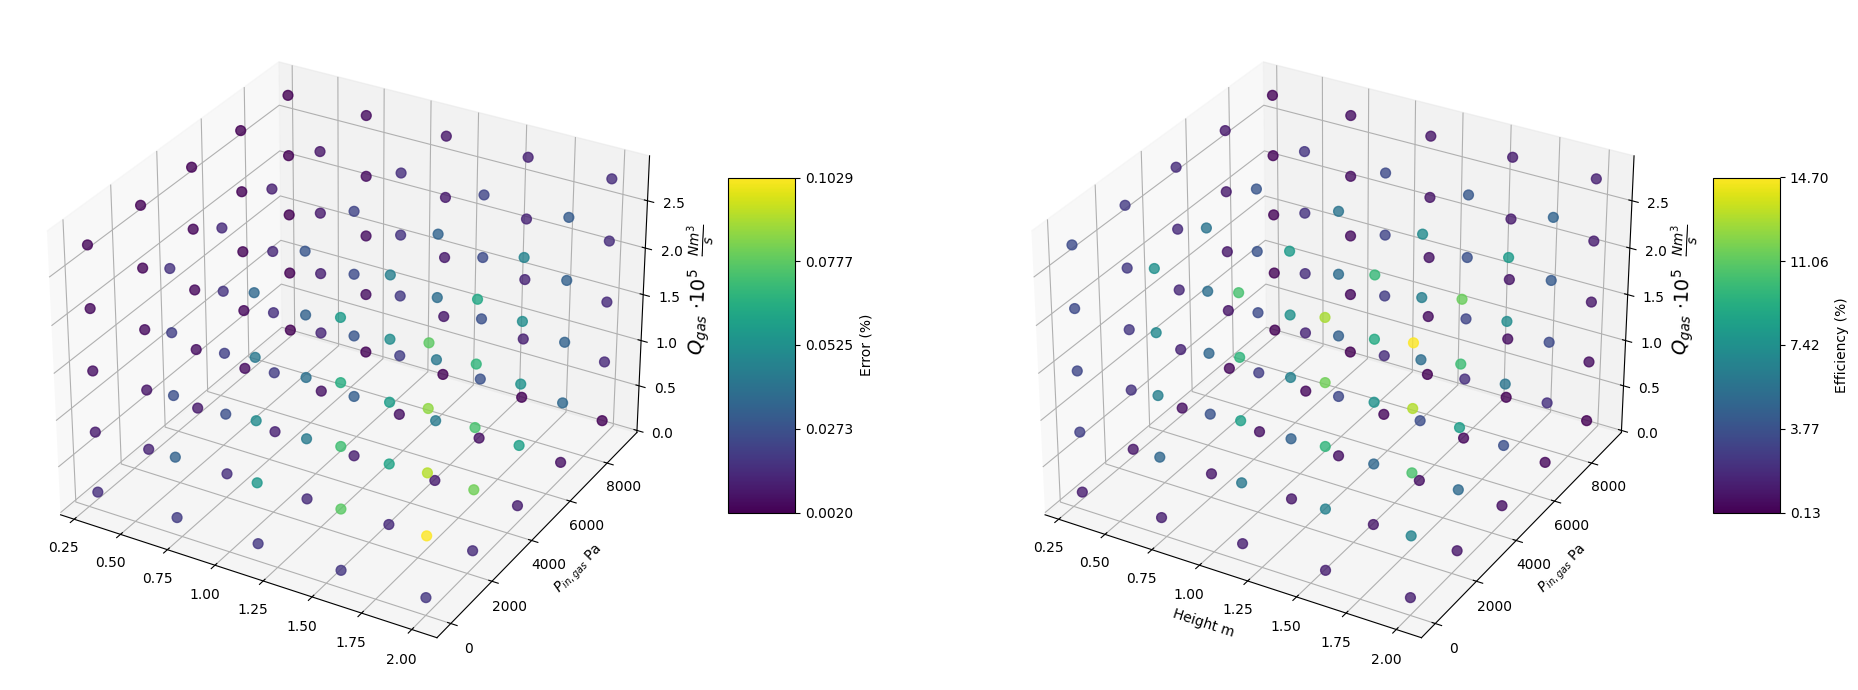

In [ ]:

# Normalize the colors based on the values in scatter_mat[:, 3] and scatter_mat[:, 4]
cmap = cm.get_cmap('viridis')
norm1 = plt.Normalize(vmin=abs(scatter_mat[:, 3]).min(), vmax=abs(scatter_mat[:, 3]).max())
norm2 = plt.Normalize(vmin=abs(scatter_mat[:, 4]).min(), vmax=abs(scatter_mat[:, 4]).max())

colors1 = np.array([
    (1, 0, 0, 1) if value > 1 else cmap(norm1(value))  # (1, 0, 0, 1) is red in RGBA
    for value in abs(scatter_mat[:, 3])
])
colors2 = np.array([
    cmap(norm2(value))  # Normalize based on scatter_mat[:, 4]
    for value in abs(scatter_mat[:, 4])
])

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})

# First subplot
sc1 = ax1.scatter(scatter_mat[:, 0], scatter_mat[:, 1], scatter_mat[:, 2]*1E5, c=colors1, s=50, alpha=0.8)
cbar1 = plt.colorbar(cm.ScalarMappable(norm=norm1, cmap=cmap), ax=ax1, shrink=0.5, aspect=5)
cbar1.set_label('Error (%)')
# Set ticks in colorbar according to scatter_mat[:, 3]
cbar1.set_ticks(np.linspace(abs(scatter_mat[:, 3]).min(), abs(scatter_mat[:, 3]).max(), num=5))

# Second subplot
sc2 = ax2.scatter(scatter_mat[:, 0], scatter_mat[:, 1], scatter_mat[:, 2]*1E5, c=colors2, s=50, alpha=0.8)
cbar2 = plt.colorbar(cm.ScalarMappable(norm=norm2, cmap=cmap), ax=ax2, shrink=0.5, aspect=5)
cbar2.set_label('Efficiency (%)')
# Set ticks in colorbar according to scatter_mat[:, 4]
cbar2.set_ticks(np.linspace(abs(scatter_mat[:, 4]).min(), abs(scatter_mat[:, 4]).max(), num=5))

#ax1.set_xlabel(r'Height m ')
ax1.set_ylabel(r'$P_{in,gas}$ Pa')
ax1.set_zlabel(r'$Q_{gas}$ $\cdot 10^5$  $\frac{Nm^3}{s}$',fontsize=14)
ax2.set_xlabel(r'Height m ')
ax2.set_ylabel(r'$P_{in,gas}$ Pa')
ax2.set_zlabel(r'$Q_{gas}$ $\cdot 10^5$  $\frac{Nm^3}{s}$',fontsize=14)
plt.tight_layout()
plt.savefig('ms_GLC_verification.png', dpi=300)
plt.show()